# Week 5: GANs Kaggle Mini Project 

## Objective 

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For this prohect,we are going to generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

The goal is to build a GAN that generates 7,000 to 10,000 Monet-style images.


## Data

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

The monet directories contain Monet paintings. We will be using these images to train our model.

The photo directories contain photos. We will Add Monet-style to these images and submit them generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but our submission file limited to 10,000 images.

Files
* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [ ]:
import numpy
numpy.version.version

In [7]:
import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LayerNormalization

import matplotlib.pyplot as plt
import numpy as np
np.bool = np.bool_

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
        if tf.config.list_physical_devices('GPU'):
            strategy = tf.distribute.MirroredStrategy()
            print("Running on GPU.")
        else:
            strategy = tf.distribute.get_strategy()
            print("Running on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Running on CPU.
Number of replicas: 1
2.18.0


In [18]:
MONET_FILENAMES = tf.io.gfile.glob('monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [20]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [21]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [22]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

# Explore Data

In [23]:
# pick a monet picture and a photo from the data sets
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

2024-12-04 21:46:26.446254: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


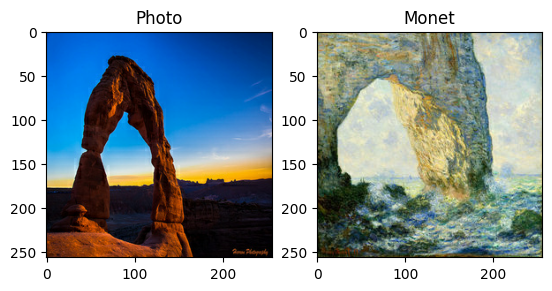

In [24]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [25]:
MONET_JPG = tf.io.gfile.glob('monet_jpg/*.jpg')
PHOTO_JPG = tf.io.gfile.glob('photo_jpg/*.jpg') 

# Display number of files in Monet and Photo directories
print('Number of images in Monet directory: ', len(MONET_JPG))
print('Number of images in photo directory: ', len(PHOTO_JPG))

Number of images in Monet directory:  300
Number of images in photo directory:  7038


# Build Generator 

Downsample method is the encoder, upsample method is the decoder.

We'll be using a UNET architecture for our CycleGAN.

A U-Net consists of an encoder (downsampler) and decoder (upsampler).

Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU

Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout -> ReLU There are skip connections between the encoder and decoder (as in the U-Net).

https://www.tensorflow.org/tutorials/generative/pix2pix gives great overview on this.

We will define our downsample and upsample methods for Generator.

## Encoder: downsample

the Downsample function reduces width and height of the image by 2, applying the filter to every other pixel.

In [26]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(
            tf.keras.layers.LayerNormalization(
                gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                axis=-1,  # Normalize along the last axis
                epsilon=1e-5  # Default epsilon, can be adjusted
            )
        )
    result.add(layers.LeakyReLU())
    return result

## Decoder: upsample

The upsample function increases the dimensions of the of the image.

In [27]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # Equivalent to InstanceNormalization
    result.add(
        tf.keras.layers.LayerNormalization(
            gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
            axis=-1,  # Normalize along the last axis
            epsilon=1e-5  # Default epsilon, can be adjusted
        )
    )
    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## Generator

The generator downsamples the input image and then upsample and establishes skip connections. Skip connections preserver image information and help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers.

In [28]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

## Build the discriminator
The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.GroupNormalization(groups=1,  # Groups of 1 channel mimic instance normalization
                                                gamma_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
                                                epsilon=1e-5
                                                )(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [30]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

# Model 

## Build the CycleGAN model

We will subclass a tf.keras.Model so that we can run fit() later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [40]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
    
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            # Calculate the gradients for generator and discriminator
            monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                      self.m_gen.trainable_variables)
            photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                      self.p_gen.trainable_variables)

            monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                          self.m_disc.trainable_variables)
            photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                          self.p_disc.trainable_variables)
            
            # Apply the gradients to the optimizer
            self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                     self.m_gen.trainable_variables))

            self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                     self.p_gen.trainable_variables))

            self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                      self.m_disc.trainable_variables))

            self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                      self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }
  


## Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [41]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [42]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), 
                                                                                            generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [43]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [44]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train the CycleGAN
Let's compile our model. Since we used tf.keras.Model to build our CycleGAN, we can just ude the fit function to train our model.

In [45]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [46]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [47]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 257s 811ms/step - monet_disc_loss: 0.5632 - monet_gen_loss: 3.7892 - photo_disc_loss: 0.6715 - photo_gen_loss: 3.4595
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 807ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.6619 - photo_disc_loss: 0.6690 - photo_gen_loss: 3.3673
Epoch 3/25


2024-12-06 10:10:04.362094: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 807ms/step - monet_disc_loss: 0.5895 - monet_gen_loss: 3.4826 - photo_disc_loss: 0.6573 - photo_gen_loss: 3.2630
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 806ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.1784 - photo_disc_loss: 0.6534 - photo_gen_loss: 3.0771
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 807ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 3.0434 - photo_disc_loss: 0.6541 - photo_gen_loss: 2.9548
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 808ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.9604 - photo_disc_loss: 0.6523 - photo_gen_loss: 2.8784
Epoch 7/25


2024-12-06 10:26:13.021491: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 807ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.9155 - photo_disc_loss: 0.6445 - photo_gen_loss: 2.8611
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 810ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 2.8845 - photo_disc_loss: 0.6439 - photo_gen_loss: 2.8171
Epoch 9/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 811ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.8547 - photo_disc_loss: 0.6384 - photo_gen_loss: 2.7979
Epoch 10/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 809ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.8279 - photo_disc_loss: 0.6482 - photo_gen_loss: 2.7379
Epoch 11/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 809ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 2.8032 - photo_disc_loss: 0.6399 - photo_gen_loss: 2.7191
Epoch 12/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 242s 807ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 2.7843 - photo_disc_loss: 0.6439 - photo_gen_loss: 2.6766
Epoch 13/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 246s 819ms/step - m

2024-12-06 10:58:37.886973: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 810ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 2.7260 - photo_disc_loss: 0.6398 - photo_gen_loss: 2.6265
Epoch 16/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 809ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 2.7037 - photo_disc_loss: 0.6399 - photo_gen_loss: 2.6024
Epoch 17/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 809ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.6835 - photo_disc_loss: 0.6568 - photo_gen_loss: 2.5397
Epoch 18/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 809ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 2.6670 - photo_disc_loss: 0.6392 - photo_gen_loss: 2.5659
Epoch 19/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 246s 818ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 2.6323 - photo_disc_loss: 0.6383 - photo_gen_loss: 2.5311
Epoch 20/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 811ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.6878 - photo_disc_loss: 0.6381 - photo_gen_loss: 2.5491
Epoch 21/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 243s 810ms/step -

# Visualize Photos

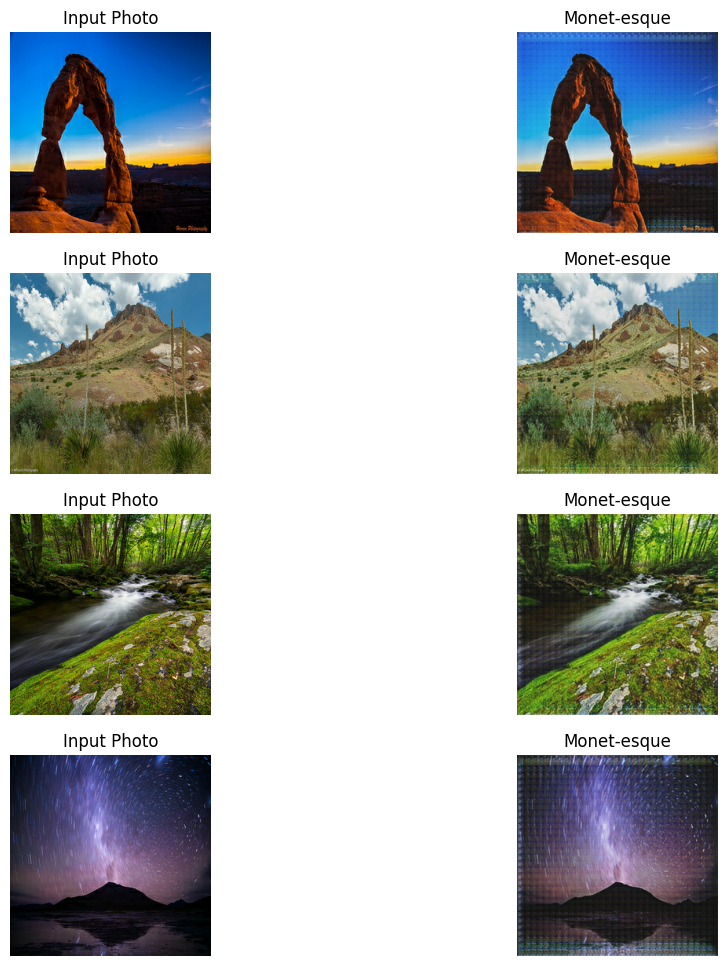

In [54]:
_, ax = plt.subplots(4, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(4)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [55]:
import PIL
! mkdir ../images

In [56]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

2024-12-06 12:09:25.941507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [58]:
import shutil
shutil.make_archive("images", 'zip', "images")

'/Users/christophermurdter/Documents/DTSA_5511_ML3/Week_5/images.zip'

# Conclusion 

This project successfully achieved its objective of creating a Generative Adversarial Network (GAN) capable of generating Monet-style images. The GAN, comprised of a generator and discriminator network, was trained using a dataset of Monet paintings (from monet_tfrec and monet_jpg directories) and photographic images (from photo_tfrec and photo_jpg directories). The generator learned to produce images "convincingly" mimicking Monet's style, successfully deceiving the discriminator. The resulting system generated between 7,000 and 10,000 Monet-style images, derived from both the training dataset's photographs. These generated images are compiled into a single zip file for submission and resulted in a score of 72. 

The successful generation of Monet-style images was facilitated by careful tuning of the GAN's parameters. This involved experimentation with various architectural choices for both the generator and discriminator, including the number of layers, filter sizes, and activation functions. The balance between the generator and discriminator was carefully monitored throughout training, employing techniques like adjusting the discriminator's learning rate relative to the generator's to maintain a competitive adversarial process. The project demonstrates the effectiveness of GANs in artistic style transfer and image generation, highlighting the importance of hyperparameter optimization in achieving optimal results. 